# Tarea 1: Redes neuronales para tareas de aprendizaje supervisado
**José Giral Barajas**

En este *notebook* incursionaremos en la implementación de redes neuronales para las tareas de clasificación. En este trabajo, implementaremos una neurona con capa de salida lineal y función de activación sigmoide para encontrar la relación entre cinco medidas morfológicas de los cangrejos Leptograpsus variegatus (tamaño del lóbulo frontal, ancho trasero, longitud del caparazón, ancho del caparazón y Profundidad del cuerpo) con el color de los mismos (azul o naranja).

## 1. Importamos algunas librerías

In [1]:
import torch
import pandas as pd
import numpy as np
import torch.nn as nn
import torch.nn.functional as F
from torch.utils.data import Dataset, DataLoader
from matplotlib import pyplot as plt

## 2. Análisis y preparación de los datos

Estaremos trabajando con la base de datos [Crab body metrics](https://www.kaggle.com/inputblackboxoutput/crab-body-metrics) la cual fue obtenida de Kaggle y recuperada de Campbell, N.A. and Mahon, R.J. (1974) A multivariate study of variation in two species of rock crab of genus Leptograpsus. Australian Journal of Zoology 22, 417–425.

Esta base de datos contiene 200 filas y ocho columnas, las cuales describen cinco mediciones morfológicas en 200 cangrejos, cada uno de algun color (azul o naranja) y de algún sexo, de la especie Leptograpsus variegatus recolectada en Fremantle, Australia Occidental. Las columnas están dispuestas de la siguiente manera:

1. **Especie (sp)**: "B" u "O" para azul (blue) o naranja (orange).
2. **Sexo (sex)**: "M" o "F" para hombre (male) o mujer (female).
3. **Indice (index)**: identificador único para cada cangreo según su color y sexo.
4. **Tamaño del lóbulo frontal (FL)**: medido en milimetros.
5. **Ancho trasero (RW)**: medido en milimetros.
6. **Longitud del caparazón (CL)**: medido en milimetros.
7. **Ancho del caparazón (CW)**: medido en milimetros.
8. **Profundidad del cuerpo (BD)**: medido en milimetros.

### 2.1. Carga y visualización de la base
Esta base de datos se encuentra en el archivo data.csv incluido en la carpeta del proyecto

In [2]:
data = pd.read_csv("data.csv", sep=',')

Veamos los primeros datos de la base de datos:

In [3]:
data.head()

,sp,sex,index,FL,RW,CL,CW,BD
0,B,M,1,8.1,6.7,16.1,19.0,7.0
1,B,M,2,8.8,7.7,18.1,20.8,7.4
2,B,M,3,9.2,7.8,19.0,22.4,7.7
3,B,M,4,9.6,7.9,20.1,23.1,8.2
4,B,M,5,9.8,8.0,20.3,23.0,8.2


Ahora, veamos los últimos datos de la base:

In [4]:
data.tail()

,sp,sex,index,FL,RW,CL,CW,BD
195,O,F,46,21.4,18.0,41.2,46.2,18.7
196,O,F,47,21.7,17.1,41.7,47.2,19.6
197,O,F,48,21.9,17.2,42.6,47.4,19.5
198,O,F,49,22.5,17.2,43.0,48.7,19.8
199,O,F,50,23.1,20.2,46.2,52.5,21.1


### 2.2. Análisis exploratorio de los datos

Analizaremos los datos para cada uno de los colores de la especie. Así, comenzamos por describir los datos para los cangrejos de color naranja

In [5]:
data_O = data[data["sp"] == "O"][["FL","RW","CL","CW","BD"]]

Vemos las distribuciones de cada una de las variables explicativas

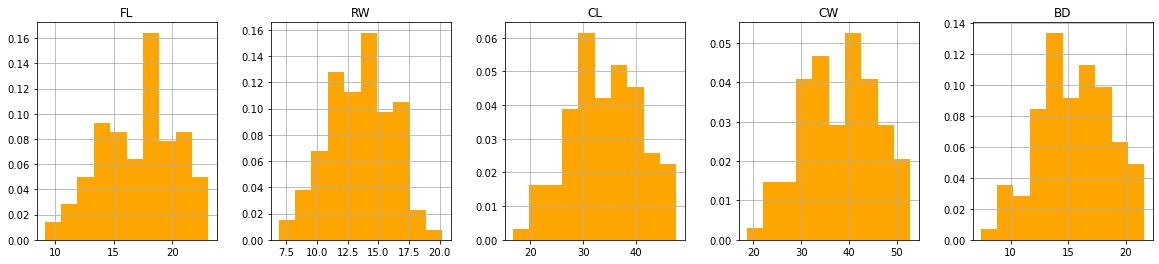

In [6]:
%matplotlib inline
data_O.hist(figsize=[20,4], layout=(1, 5), color="orange", density=True)
plt.show()

Vemos un resumen general de las medidas de disperciónd de los datos

In [7]:
data_O.describe()

,FL,RW,CL,CW,BD
count,100.000000,100.00000,100.000000,100.000000,100.000000
mean,17.110000,13.54900,34.153000,38.112000,15.478000
std,3.275575,2.60553,6.764262,7.540922,3.151481
min,9.100000,6.90000,16.700000,18.600000,7.400000
25%,14.525000,11.50000,29.200000,32.350000,13.250000
50%,17.500000,13.65000,34.550000,38.950000,15.550000
75%,19.475000,15.55000,39.400000,43.675000,17.825000
max,23.100000,20.20000,47.600000,52.800000,21.600000


Ahora, haremos el mismo análiziz para los datos de los cangrejos de color azul

In [8]:
data_B = data[data["sp"] == "B"][["FL","RW","CL","CW","BD"]]

Vemos las distribuciones de cada una de las variables explicativas

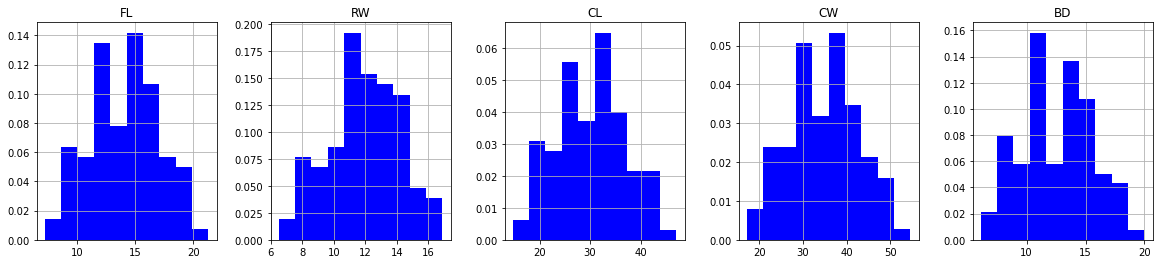

In [9]:
%matplotlib inline
data_B.hist(figsize=[20,4], layout=(1, 5), color="blue", density=True)
plt.show()

Vemos un resumen general de las medidas de disperciónd de los datos

In [10]:
data_B.describe()

,FL,RW,CL,CW,BD
count,100.00000,100.000000,100.000000,100.000000,100.000000
mean,14.05600,11.928000,30.058000,34.717000,12.583000
std,3.01961,2.279291,6.902703,7.866038,3.067887
min,7.20000,6.500000,14.700000,17.100000,6.100000
25%,11.80000,10.600000,24.850000,29.125000,10.400000
50%,14.45000,12.000000,30.100000,35.200000,12.600000
75%,16.12500,13.525000,34.600000,40.300000,14.900000
max,21.30000,16.900000,47.100000,54.600000,20.000000


### 2.3. Estandarización de los datos

Usamos la transformación
$$z_i \longrightarrow \frac{x_i-\bar{X}}{sd(X)}$$

Estandarizamos la variable FL:

In [11]:
mean_FL = data['FL'].mean()
std_FL = data['FL'].std()
data['Normalized_FL'] = data['FL'].apply(lambda x: (x - mean_FL)/std_FL)

Estandarizamos la variable RW:

In [12]:
mean_RW = data['RW'].mean()
std_RW = data['RW'].std()
data['Normalized_RW'] = data['RW'].apply(lambda x: (x - mean_RW)/std_RW)

Estandarizamos la variable CL:

In [13]:
mean_CL = data['CL'].mean()
std_CL = data['CL'].std()
data['Normalized_CL'] = data['CL'].apply(lambda x: (x - mean_CL)/std_CL)

Estandarizamos la variable CW:

In [14]:
mean_CW = data['CW'].mean()
std_CW = data['CW'].std()
data['Normalized_CW'] = data['CW'].apply(lambda x: (x - mean_CW)/std_CW)

Estandarizamos la variable BD:

In [15]:
mean_BD = data['BD'].mean()
std_BD = data['BD'].std()
data['Normalized_BD'] = data['BD'].apply(lambda x: (x - mean_BD)/std_BD)

### 2.4. Definición de nuestra variable Respuesta

En esta parte simplemente identificamos a los cangrejos de color azul con el número 1 y a los congrejos de color naranja con el número 0 para más adelante, a la hora de hacer la clasificación, trabajar con números. 

In [16]:
def identificador(x):
    if x == "B":
        return 1
    else:
        return 0
    
data['SP'] = data['sp'].apply(identificador)

### 2.5. Visualización de la base de datos aumentada

In [17]:
data.head()

,sp,sex,index,FL,RW,CL,CW,BD,Normalized_FL,Normalized_RW,Normalized_CL,Normalized_CW,Normalized_BD,SP
0,B,M,1,8.1,6.7,16.1,19.0,7.0,-2.140860,-2.346561,-2.248285,-2.212220,-2.052837,1
1,B,M,2,8.8,7.7,18.1,20.8,7.4,-1.940592,-1.957961,-1.967346,-1.983561,-1.936041,1
2,B,M,3,9.2,7.8,19.0,22.4,7.7,-1.826153,-1.919101,-1.840923,-1.780307,-1.848444,1
3,B,M,4,9.6,7.9,20.1,23.1,8.2,-1.711715,-1.880241,-1.686407,-1.691384,-1.702449,1
4,B,M,5,9.8,8.0,20.3,23.0,8.2,-1.654496,-1.841381,-1.658313,-1.704087,-1.702449,1


In [18]:
data.tail()

,sp,sex,index,FL,RW,CL,CW,BD,Normalized_FL,Normalized_RW,Normalized_CL,Normalized_CW,Normalized_BD,SP
195,O,F,46,21.4,18.0,41.2,46.2,18.7,1.664223,2.044619,1.277500,1.243084,1.363448,0
196,O,F,47,21.7,17.1,41.7,47.2,19.6,1.750052,1.694879,1.347735,1.370117,1.626240,0
197,O,F,48,21.9,17.2,42.6,47.4,19.5,1.807271,1.733739,1.474157,1.395524,1.597040,0
198,O,F,49,22.5,17.2,43.0,48.7,19.8,1.978929,1.733739,1.530345,1.560667,1.684638,0
199,O,F,50,23.1,20.2,46.2,52.5,21.1,2.150587,2.899539,1.979847,2.043393,2.064225,0


### 2.6. Diseño de la base de datos

Comenzamos por separar la base de datos en un grupo de entrenamiento y uno de prueba de forma que el 90% de los datos sea de entrenamiento y el 10% de los datos sea de prueba.

In [19]:
msk = np.random.rand(len(data)) < 0.9
training_data = data[msk]
test_data = data[~msk]

Creamos la instancia de Dataset que usaremos para manejar la información 

In [20]:
class DataFrameDataset(Dataset):
    def __init__(self, data, x_names:list, y_name):
        X = data[x_names] # Estas columnas corresponden a las variables explicativas
        Y = data[y_name] # Esta columna corresponde a la variable de clasificacion
        self.X = torch.from_numpy(X.to_numpy()).to(dtype=torch.float32)
        self.Y = torch.from_numpy(Y.to_numpy()).to(dtype=torch.float32)

    def __len__(self):
        return self.Y.size()[0]

    def __getitem__(self, idx):
        x = self.X[idx, :]
        y = self.Y[idx]
        return x, y

Definimos los conjuntos de datos con las variables epxlicativas estandarizadas y la nueva variable respuesta numérica.

In [21]:
x_names = ['Normalized_FL', 'Normalized_RW', 'Normalized_CL', 'Normalized_CW', 'Normalized_BD']
train_set = DataFrameDataset(training_data, x_names, 'SP')
test_dataset = DataFrameDataset(test_data, x_names, 'SP')

Partimos a la mitad el `test_dataset` de tal forma que tengamos el 5% de los datos para la validación y el 5% de los datos para prueba.

In [22]:
msk = np.random.rand(len(test_dataset)) < 0.5
val_set = torch.utils.data.Subset(test_dataset, np.where(msk)[0])
test_set = torch.utils.data.Subset(test_dataset, np.where(~msk)[0])

Observamos el tamaño de los conjuntos de datos.

In [23]:
n_train = len(train_set)
n_val = len(val_set)
n_test = len(test_set)

for n, name in zip([n_train, n_val, n_test], ['train', 'val', 'test']):
  print('# '+name+': {}'.format(n))

# train: 176
# val: 10
# test: 14


### 2.7. DataLoader

Recordemos que esta clase en empaqueta a las particiones del conjunto de datos llamados *batches* o *mini-batches*.

$$\mathcal{D}_{train} = \mathcal{D}_{(1)} \cup \mathcal{D}_{(2)} \cup \cdots \cup \mathcal{D}_{(n_{batch})}$$

$$\mathcal{D}_{(j)} = X_{(j)} \times Y_{(j)} $$

Donde $n_{batch}$ es el número de particiones que se hizo sobre el conjunto de datos de entrenamiento original. Dependiendo del numero de bathces, el resultado que obtenemos esto es un tensor de la forma 

$$(n_{batch},batch_{size},tamaño_{vector})$$

In [24]:
batch_size = 4
train_dataloader = DataLoader(train_set, batch_size=batch_size, shuffle=True)
val_dataloader = DataLoader(val_set, batch_size=batch_size, shuffle=True)
test_dataloader = DataLoader(test_set, batch_size=n_test)

## 3. Definición y entrenamiento de la red neuronal

Comencemos por observar que el tamaño de nuestros mini-batches, $k$, es 4 en casi todas partes.
Entonces la red neuronal que declararemos para la tarea de clasificación es
$$f_a'(\cdot|\theta):\mathbb{R}^{k\times5}\rightarrow\mathbb{R}^{k\times c}\text{ con }a'=\langle [5, 1], \{\text{Linear}\}\rangle$$
y así
$$f_a(\cdot|\theta)=Sigmoid\circ f_a'(\cdot|\theta)$$

**Sobre la función de activación sigmoide:**

Sea $\sigma : \mathbb{R} \rightarrow [0, 1]$ una función dada por
$$\sigma(x) = \frac{1}{1+ e^{-x}}\quad \forall x \in \mathbb{R}.$$

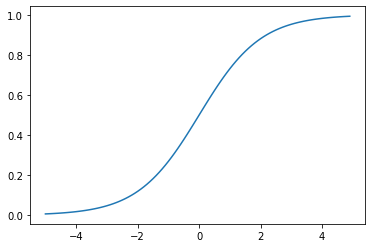

In [25]:
x = torch.arange(-5., 5., 0.1)
y = torch.sigmoid(x)
plt.plot(x.numpy(), y.numpy())
plt.show()

### 3.1. Implementación de la primera red

In [26]:
class ClassificationNet1(nn.Module):

    def __init__(self, n_in, n_out):
        super(ClassificationNet1, self).__init__()
        self.in_features = n_in
        self.layer = nn.Linear(in_features=n_in, out_features=n_out)

        
    def forward(self,x):
        out = torch.sigmoid(self.layer(x))
        return out
        
model = ClassificationNet1(5,1)

### 3.2. Optimizador y función de costo

La idea subyacente es hacer una regresión lineal con función de enlace logit dado que solo tenemos dos clases. Entonces usaremos la función de error cuadrático medio (*MSE*) para entrenar a la red neuronal.

$$MSE(w, b; Y, X) = \frac{1}{k}\sum_{x, y \in X, Y}(y -(wx+b))^2$$

Utilizaremos como optimizador `Adam` del módulo `torch.optim` que es la implementación del algoritmo de Adam visto en las clases pasadas.

In [27]:
from torch.optim import Adam

cost = nn.MSELoss()
optimizer = Adam(model.parameters(), lr = 0.001)

### 3.3. Función para la actualización de los parámetros

In [28]:
def update_parameters(model, dataloader, optimizer, criterion, train=True):
    running_loss = 0.0
    for i, data in enumerate(dataloader, 0):
        X, Y = data
        n = len(X)
        X = X.reshape((n, model.in_features)) # Corregimos el tamaño (necesario en dimension 1)
        m = len(Y)
        Y = Y.reshape((m, 1)) # Corregimos el tamaño
        if train:
            optimizer.zero_grad() # Reiniciamos el gradiente
        pred = model(X) # forward pass 
        loss = criterion(pred, Y) # evaluación de predicción
        if train:
            loss.backward() # cálcula las derivadas 
            optimizer.step() # paso de optimización 

        running_loss += loss.item()
        avg_loss = running_loss/(i + 1)
    return avg_loss

### 3.4. Entrenamiento de la red

In [29]:
epoch_loss = list()
val_loss = list()
epochs = 200

for epoch in range(epochs):
    loss_train = update_parameters(model, train_dataloader, optimizer, cost)
    loss_val = update_parameters(model, val_dataloader, None, cost, train=False)
    epoch_loss.append(loss_train)
    val_loss.append(loss_val)
    if epoch % 5 == 0:
        print('epoch {}, train loss {}, val loss {}'.format(epoch, loss_train, loss_val))

epoch 0, train loss 0.24013040553439746, val loss 0.23239673674106598
epoch 5, train loss 0.2157072854990309, val loss 0.19246936837832132
epoch 10, train loss 0.2087787643752315, val loss 0.1939868281284968
epoch 15, train loss 0.20413103013892064, val loss 0.16086718440055847
epoch 20, train loss 0.19975417920134284, val loss 0.16172321140766144
epoch 25, train loss 0.19568072513423182, val loss 0.1697338024775187
epoch 30, train loss 0.19140813939950682, val loss 0.1726190149784088
epoch 35, train loss 0.18757108328017322, val loss 0.16682213296492895
epoch 40, train loss 0.18364411795681174, val loss 0.16042077541351318
epoch 45, train loss 0.17983675934374332, val loss 0.14177289605140686
epoch 50, train loss 0.17602132413197646, val loss 0.1455029994249344
epoch 55, train loss 0.17224092341282152, val loss 0.153185173869133
epoch 60, train loss 0.1685499120503664, val loss 0.14120525121688843
epoch 65, train loss 0.16504796966910362, val loss 0.17296692232290903
epoch 70, train l

Hacemos una gráfica de la evolución de la función de perdida en el tiempo

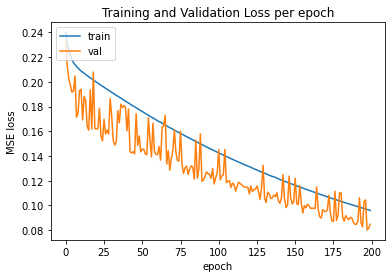

In [30]:
plt.plot(epoch_loss)
plt.plot(val_loss)
plt.title('Training and Validation Loss per epoch')
plt.ylabel('MSE loss')
plt.xlabel('epoch')
plt.legend(['train', 'val'], loc='upper left')
plt.show()

Probamos el modelo con los datos de prueba

In [31]:
data = next(iter(test_dataloader))
X, Y = data
n = len(X)
X = X.reshape((n, model.in_features)) # -> Corrección de tamaño
Y = Y.reshape((n, 1)) # -> Corrección de tamaño
pred = model(X)
error = cost(Y, pred)
print('error de prueba :{}'.format(error.item()))

error de prueba :0.08981017023324966
